In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [ ]:
train_dir = "/content/drive/MyDrive/All_Dataset_Folder/1 Sweet Pumpkin Dataset/1 Sweet Pumpkin Dataset/train"
val_dir = "/content/drive/MyDrive/All_Dataset_Folder/1 Sweet Pumpkin Dataset/1 Sweet Pumpkin Dataset/val"

In [ ]:
class_names = sorted(os.listdir(train_dir))
class_names

['Downy mildew disease of sweet pumpkin',
 'Fresh leaf of sweet pumpkin',
 'Leaf curl disease of sweet pumpkin',
 'Mosaic diease of sweet pumpkin',
 'Sweet pumpkin red beetle']

In [ ]:
class_dis = [len(os.listdir(train_dir + '/' + name)) for name in class_names]
class_dis

[180, 180, 180, 180, 180]

In [ ]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [ ]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [ ]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 720 images belonging to 5 classes.
Found 180 images belonging to 5 classes.


In [ ]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 100 images belonging to 5 classes.


In [ ]:
def plot_images(data, class_names):

    r, c = 3, 4
    imgLen = r*c

    plt.figure(figsize=(20, 15))
    i = 1

    for images, labels in iter(data):


        id = np.random.randint(len(images))
#         img = images[id].numpy().astype('uint8')
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]

        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()

        i+=1
        if i > imgLen:
            break
    plt.show()

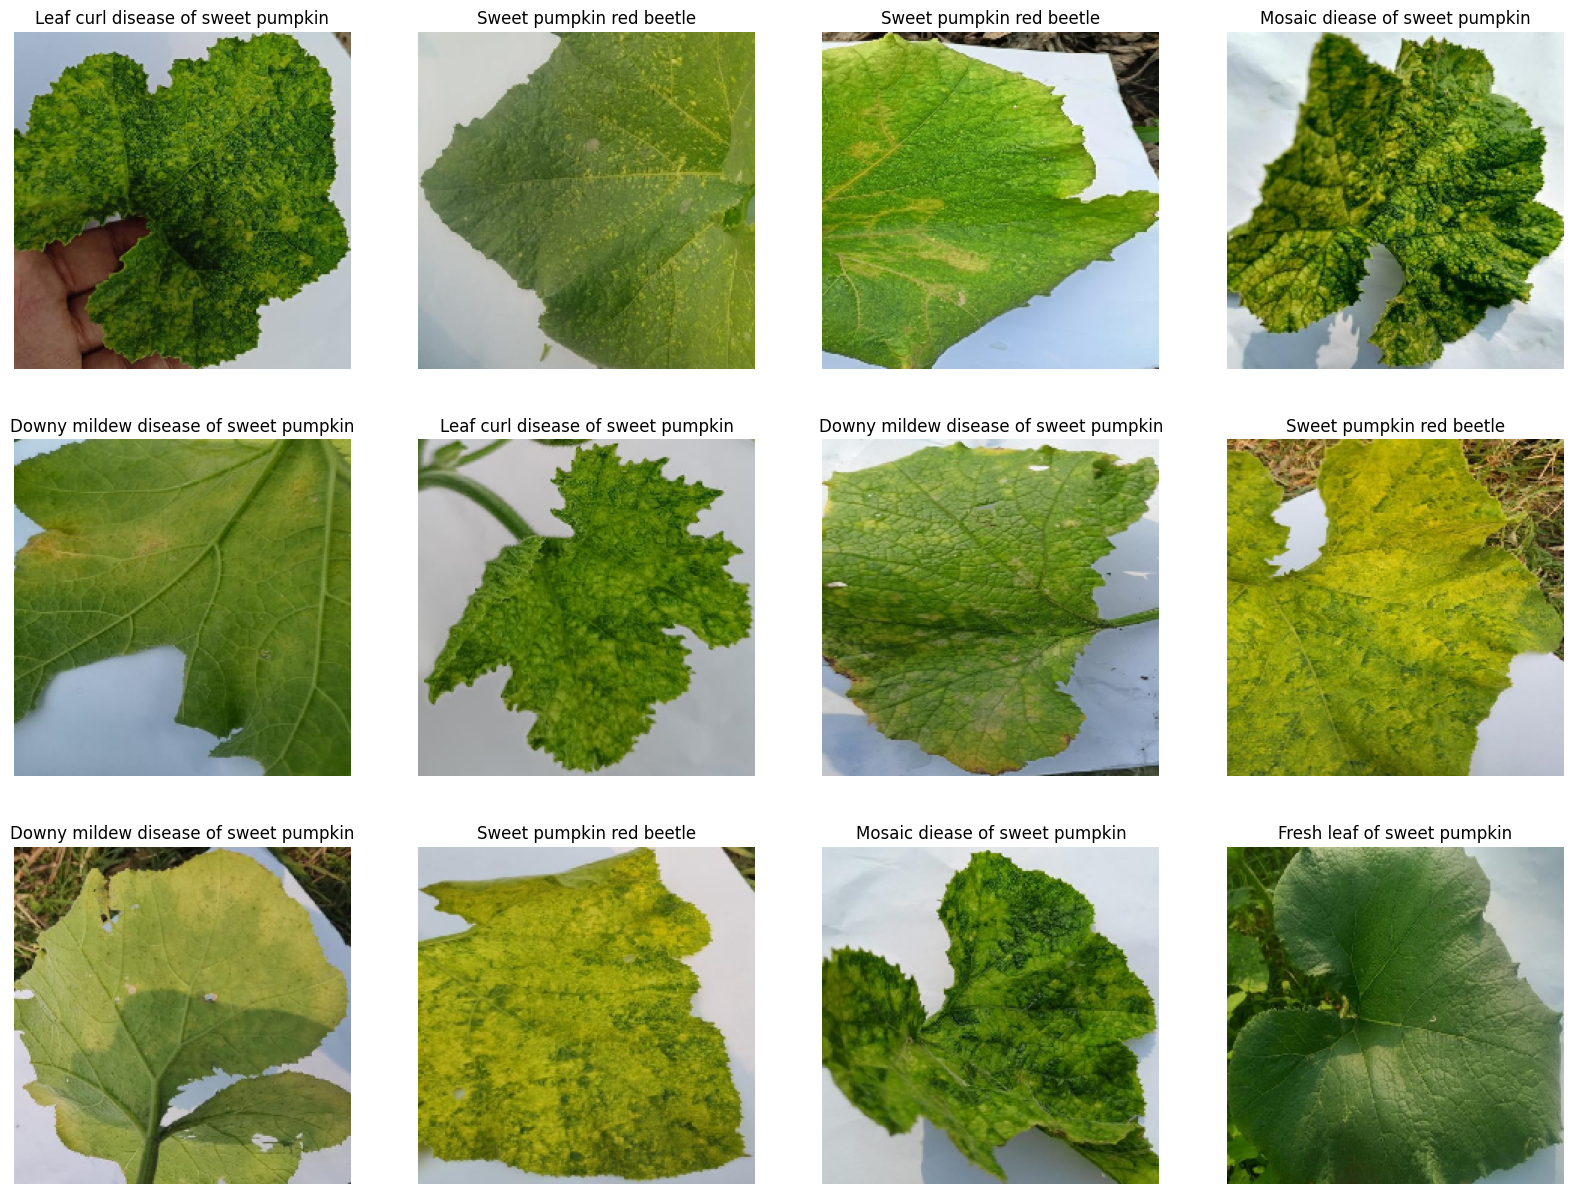

In [ ]:
plot_images(train_ds, class_names)

In [ ]:
def get_model():

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layers in base_model.layers:
        layers.trainable = False

    base_model_output = base_model.output

    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=8,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/8
23/23 [==============================] - 154s 6s/step - loss: 4.5837 - accuracy: 0.3611 - val_loss: 1.0281 - val_accuracy: 0.5833
Epoch 2/8
23/23 [==============================] - 129s 6s/step - loss: 1.0840 - accuracy: 0.5750 - val_loss: 1.2287 - val_accuracy: 0.5556
Epoch 3/8
23/23 [==============================] - 127s 6s/step - loss: 0.8155 - accuracy: 0.6861 - val_loss: 0.9856 - val_accuracy: 0.6111
Epoch 4/8
23/23 [==============================] - 131s 6s/step - loss: 0.5575 - accuracy: 0.7972 - val_loss: 0.5428 - val_accuracy: 0.7944
Epoch 5/8
23/23 [==============================] - 126s 6s/step - loss: 0.6067 - accuracy: 0.7861 - val_loss: 0.5032 - val_accuracy: 0.8056
Epoch 6/8
23/23 [==============================] - 127s 6s/step - loss: 0.2564 - accuracy: 0.9292 - val_loss: 0.4855 - val_accuracy: 0.7944
Epoch 7/8
23/23 [==============================] - 125s 6s/step - loss: 0.1469 - accuracy: 0.9653 - val_loss: 0.5060 - val_accuracy: 0.7667
Epoch 8/8
23/23 [===

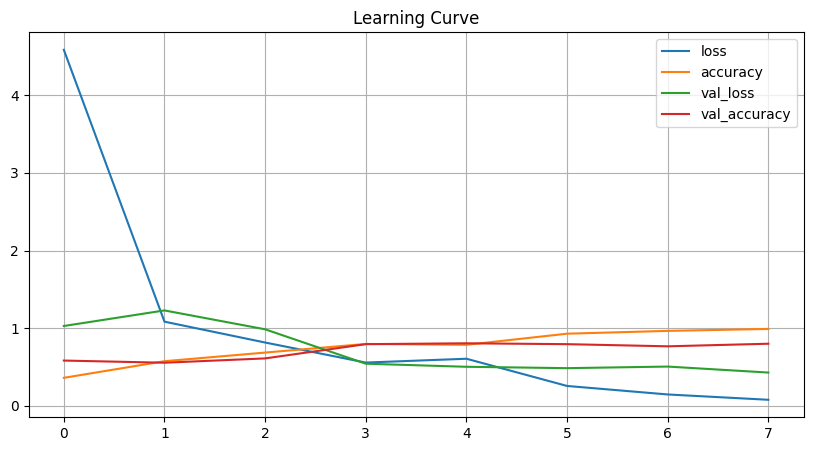

In [ ]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

In [ ]:
def predictImages(data, class_names, model):

    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1

    for images, labels in iter(data):

        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)

        plt.subplot(r, c, i)
        plt.imshow(img[0])

        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]

        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()

        i+=1
        if i > imgLen:
            break

    plt.show()

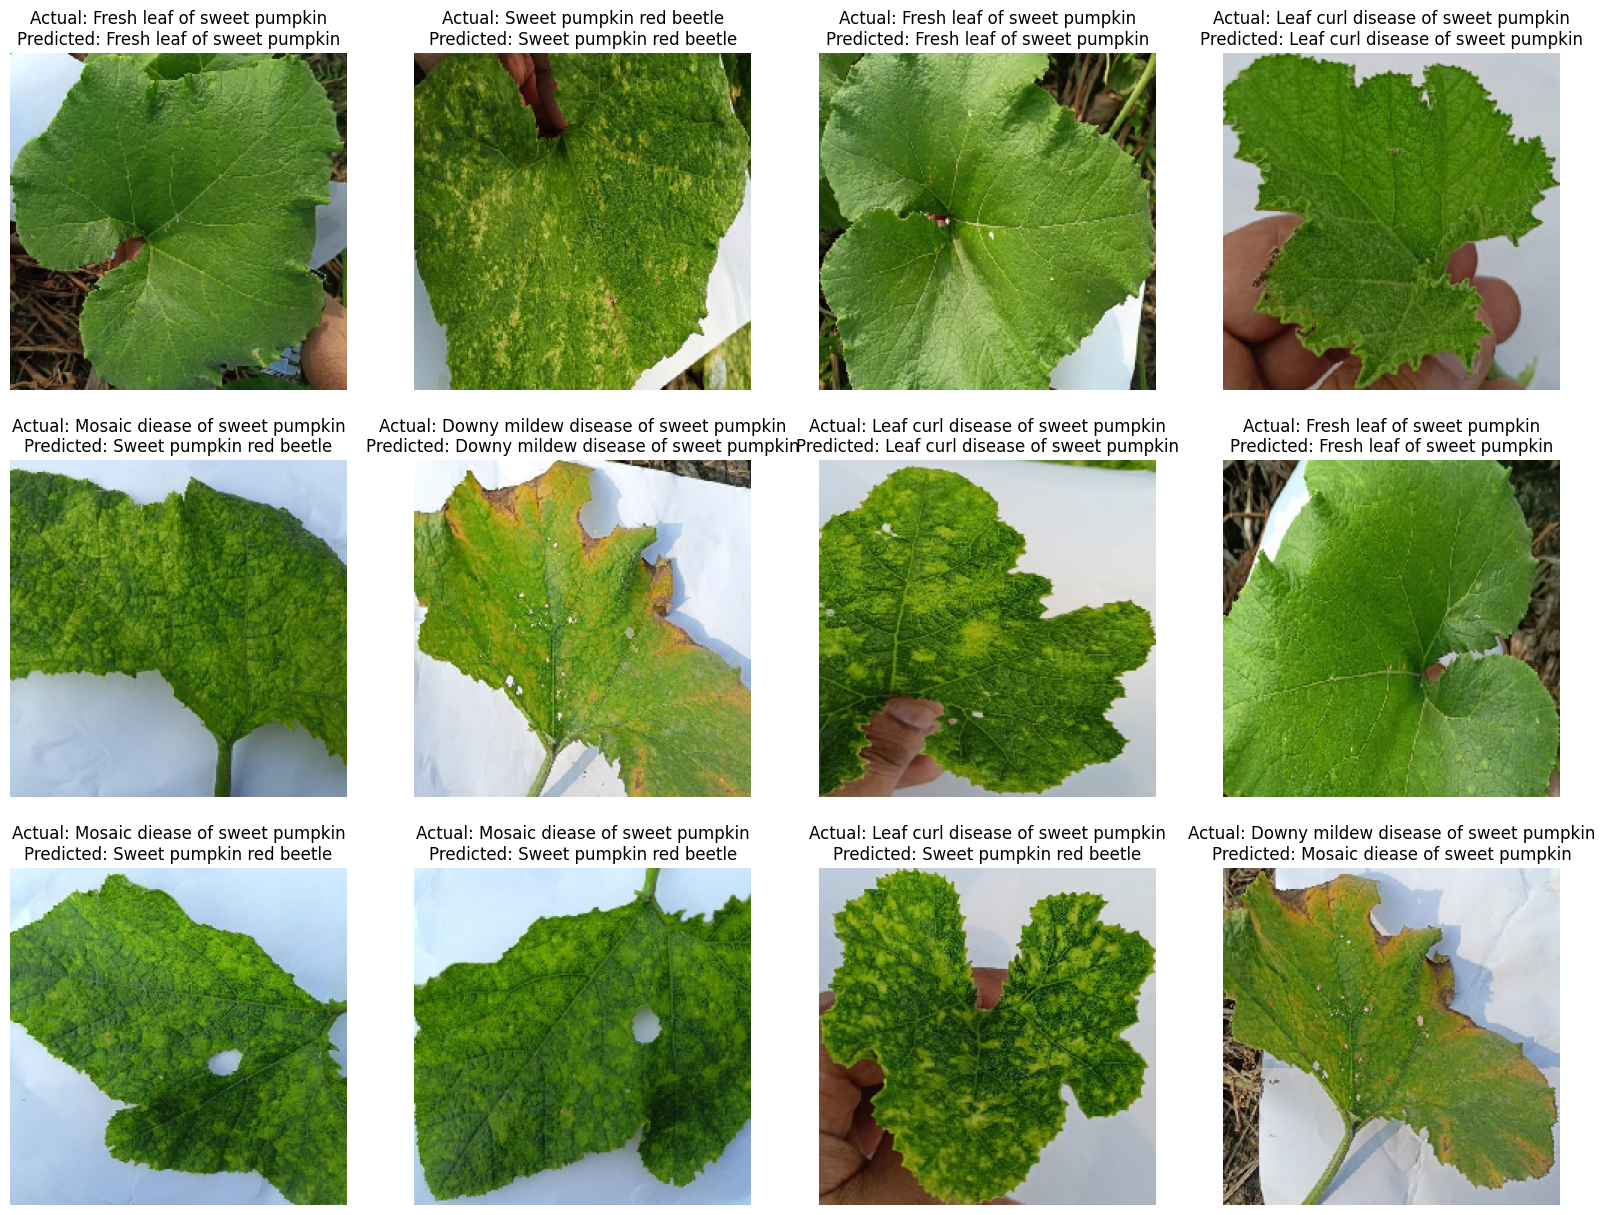

In [ ]:
predictImages(test_ds, class_names, model)